In [1]:
"""
Created on Thu Sep 19 08:25:17 2019
SCD_BEC.py
@author: Young Joon Song
"""

import numpy as np
from matplotlib import pyplot as plt

np.random.seed(103)
n_power=7
CodeRate=0.5
N_length=int(2**n_power)
msg_length=int(CodeRate*N_length)
frozen_length=N_length-msg_length
TotalNumMessage=4

Prob_start=0.15
Prob_delta=0.05
BEC_count=8
BECs=np.arange(Prob_start,Prob_start+BEC_count*Prob_delta,Prob_delta)


file=open("SCDBEC.txt","w")
file.write("BER for polar code over BEC channel of code length ")
file.write(str(N_length))
file.write(", Total number of messages: ")
file.write(str(TotalNumMessage))
file.write("\n")
file.write("Delta:  BER:   \n ")


def BhanttacharyyaParameterBEC():
    prob_erase=0.5
    Z_before=[]
    Z_after=[]
    CapacitySplit=np.ones(N_length)
    Z_index_sorted=np.arange(N_length)
    Z_before.append(prob_erase)  # Initial value of Bhattacharyya parameter #
    i=0
    while (i < n_power):
        N_half=len(Z_before)
        for j in range(N_half):
            Z_Value = 2*Z_before[j] - Z_before[j]**2
            if Z_Value < 10**-30: 
                Z_Value=10**-30
            elif Z_Value >= (1 - 10**-30): 
                Z_Value=1 - 10**-30
            Z_after.append(Z_Value)
            
            Z_Value=Z_before[j]**2
            if Z_Value < 10**-30: 
                Z_Value=10**-30
            elif Z_Value >= (1 - 10**-30): 
                Z_Value=1 - 10**-30
            Z_after.append(Z_Value)
#        print("Z:",Z_after)    
        Z_before=Z_after
        Z_after=[]
        i+=1
    
    Z_sorted=sorted(Z_before,reverse=True)
    for i in range(N_length):
        Z_index_sorted[i]=Z_before.index(Z_sorted[i])
        Z_before[Z_index_sorted[i]]=-99
    return (Z_after, Z_index_sorted)


def LLR_Value_BEC(R_bit):
    return{0:77,1:-77,-1:0}[R_bit]
    
def AllGeneratorMatrixPolarCode():
    GenAll={}
    g_before=np.ones([1,1])
    GenAll[0]=g_before
    n_variable=0
    while (n_variable < n_power):
        n_col_before=2**n_variable # number of columns for g_before matrix
        n_row_before=2**n_variable # number of rows for g_before matrix
        n_variable+=1
        g_after=np.ones([2**n_variable,2**n_variable])
        for i in range(n_col_before):
            g_after[0:n_col_before,2*i]=g_before[:,i]
            g_after[0:n_col_before,2*i+1]=np.zeros(n_col_before)
            g_after[n_row_before::,2*i]=g_before[:,i]
            g_after[n_row_before::,2*i+1]=g_before[:,i]
#        print(g_after)
        g_before=g_after
        GenAll[n_variable]=g_before
    return GenAll

'''
from Decimal to Bits in List type of lenght BitLength.
From the left to right bit positios, the order is from MSB to LSB.
'''
def D2B(BitLength,DecimalNum): 
    BinList=list(bin(DecimalNum))
    del BinList[0:2]
    Len_BinList=len(BinList)
    for i in range(Len_BinList): BinList[i]=int(BinList[i]) 
    if Len_BinList>BitLength:
        print('Not enough BitLength , DecimalNum is too big. I will return empty List []. Try again!!\n')
        return []
    elif Len_BinList==BitLength: return BinList
    else:
        diff_len=BitLength-Len_BinList
        while(diff_len>0):
            BinList.insert(0,0)
            diff_len-=1
        return BinList

def B2D(Bin_vector): ## binary to decimal conversion
    Decimal_num=0
    for i in range(len(Bin_vector)):
        Decimal_num += Bin_vector[i]*2**(len(Bin_vector)-1-i)
    return int(Decimal_num)
    
def NodeOutValue(L_In,R_In):
    LEFT=np.exp(L_In)
    RIGHT=np.exp(R_In)
    N_Out=np.log(1+LEFT*RIGHT)-np.log(LEFT+RIGHT)
    if N_Out >= 77: N_Out=77
    elif N_Out < -77: N_Out=-77
    return round(N_Out,5)

def NodeOutValueRef(L_In,R_In,Ref):
    N_Out=((-1)**Ref)*L_In + R_In
    if N_Out >= 77: N_Out=77
    elif N_Out < -77: N_Out=-77
    return round(N_Out,5)

G_All=AllGeneratorMatrixPolarCode()
#print('All Gen:\n',G_All)

(Z_BEC,Z_decending_index_BEC)=BhanttacharyyaParameterBEC()
#print("Z:\n",Z_BEC)
print("index sorted:",Z_decending_index_BEC)

SelectedBitsPositions=np.ones(msg_length)
for i in range(msg_length):
    SelectedBitsPositions[i]=Z_decending_index_BEC[frozen_length+i]
#print('SelectedBitsPositions',SelectedBitsPositions)
SelectedBitsPositions.sort()
print('Sorted SelectedBitsPositions',SelectedBitsPositions)

FrozenBitsPositions=np.ones(frozen_length)
for i in range(N_length-msg_length):
    FrozenBitsPositions[i]=Z_decending_index_BEC[i]
#print('Frozen Bits Positions:',FrozenBitsPositions)

FrozenBitsPositions.sort()
print('sorted Frozen Bits Positions:',FrozenBitsPositions)

print('Generator Matrix:\n',G_All[n_power])

BERs=[]
for EraseProb_cnt, EraseProb in enumerate(BECs):
    TotalErrorBits=0
    for MessageNo in range(TotalNumMessage):
        msg=np.random.randint(0,2,size=msg_length)
     #   print('message bits:',msg)
        uncodedbits=np.zeros(N_length)
        decodedbits=[]
       
        for i in range(msg_length):
            uncodedbits[int(SelectedBitsPositions[i])]=msg[i]
     #   print("uncoded bits with frozen",uncodedbits)  
        
        codeword=np.matmul(uncodedbits,G_All[n_power])%2
     #   print("polar codeword:",codeword)
    
        ReceviedBEC=[]
        for i in range(N_length):
            if(np.random.uniform(low=0,high=1) > EraseProb):
                ReceviedBEC.append(codeword[i])
            else:
                ReceviedBEC.append(-1)
     #   print('Received BEC:',ReceviedBEC)
        ''' -1 means earased '''
        LLR_BEC=np.ones(N_length)
        for i in range(N_length):
            LLR_BEC[i]=LLR_Value_BEC(ReceviedBEC[i])
     #   print('LLR BEC',LLR_BEC)
        Remain_FBPositions=list(FrozenBitsPositions)
    #    print("Remaing FB positions",Remain_FBPositions)
        
        for CurrentBitNumber in range(N_length):
            Binary_CurrentBitNumber=D2B(n_power,CurrentBitNumber)
            length_Remain_FBPositions=len(Remain_FBPositions)
            FrozenBitAssigned = False
            if CurrentBitNumber in Remain_FBPositions:
                FrozenBitAssigned = True
                decodedbits.append(0)
                Remain_FBPositions.remove(CurrentBitNumber)
      #          print("Remaing FB positions",Remain_FBPositions)
        
            if (FrozenBitAssigned==False):
       #         print('Decoded bits until now:',decodedbits)
        #        print('Bit No. to be decoded:',CurrentBitNumber)
         #       print('Binary of bit index:',Binary_CurrentBitNumber)
                TreeNodeBitNumbers={}
                for TreeLevelNo in range(n_power):
                    NodeBitSize=Binary_CurrentBitNumber[(n_power-1)-TreeLevelNo]*(2**TreeLevelNo)
                    TreeNodeBitNumbers[TreeLevelNo]=NodeBitSize
          #      print('Tree Bit numbers',TreeNodeBitNumbers)
                cnt_TreeAssignedBits=0
                TreeAssignedBits={}
                TreeLevelNo=n_power-1
                while (cnt_TreeAssignedBits < CurrentBitNumber):
                    TreeAssignedBits[TreeLevelNo]=decodedbits[cnt_TreeAssignedBits:cnt_TreeAssignedBits+TreeNodeBitNumbers[TreeLevelNo]]
                    cnt_TreeAssignedBits+=TreeNodeBitNumbers[TreeLevelNo]
                    TreeLevelNo-=1
           #     print('Assigned bits:',TreeAssignedBits)
                NodeInputs=LLR_BEC
                for TreeLevelNo in range(n_power-1,-1,-1):
                    NodeNum=int(2**TreeLevelNo)
                    NodeOutputs=np.ones(NodeNum)
                    if (TreeNodeBitNumbers[TreeLevelNo] == 0):
                        for NodeCnt in range(NodeNum):
                            LeftInput=NodeInputs[2*NodeCnt]
                            RightInput=NodeInputs[2*NodeCnt+1]
                            NodeOutputs[NodeCnt]=NodeOutValue(LeftInput,RightInput)
                    else:
                        NodeControlValues=np.matmul(TreeAssignedBits[TreeLevelNo],G_All[TreeLevelNo])%2
        #                print('Node control bits at level no:',str(TreeLevelNo),'is',NodeControlValues)
                        for NodeCnt in range(NodeNum):
                            LeftInput=NodeInputs[2*NodeCnt]
                            RightInput=NodeInputs[2*NodeCnt+1]
                            Ref_Value=NodeControlValues[NodeCnt]
                            NodeOutputs[NodeCnt]=NodeOutValueRef(LeftInput,RightInput,Ref_Value)
                    NodeInputs=NodeOutputs
       #             print("Node Outputs:",NodeOutputs)
                if (NodeOutputs[0] >= 0):
                    decodedbits.append(0)
                else:
                    decodedbits.append(1)
        #        print('Decoded bits:',decodedbits)
        EstimatedMessage=[]
        for i in range(msg_length):
            EstimatedMessage.append(decodedbits[int(SelectedBitsPositions[i])])
      #  print("Estimated message is:",EstimatedMessage)
        NumErrors=0
        for i in range(msg_length):
            if (EstimatedMessage[i] != msg[i]): NumErrors+=1
    #    print('Error count:',NumErrors)
        TotalErrorBits+=NumErrors
        ber=NumErrors/msg_length
    #    print('ber:',ber)
    BER=TotalErrorBits/(msg_length*TotalNumMessage)
    print('Erasure Prob:',EraseProb,'  BER:',BER)
    BERs.append(BER)
    file.write(str(BECs[EraseProb_cnt]));file.write("        "); file.write(str(BER))
    file.write("\n")
print('Erasure Probs. over BECs:',BECs)
print('BERs for each BEC:',BERs)

plt.title('BER over BEC')    
plt.plot(BECs,BERs,'m*')
plt.yscale('log')
plt.xlabel('Prob. of Erasure',size=12)
plt.ylabel('BER',size=12)
plt.legend(('Polar Code',),loc=0, shadow=True)
plt.grid(True)
plt.show()
file.close()
'''
plt.legend() 
location string and corresponding location number   
'best' 0 
'upper right' 1 
'upper left' 2 
'lower left' 3 
'lower right' 4 
'right' 5 
'center left' 6 
'center right' 7 
'lower center' 8 
'upper center' 9 
'center' 10 
'''



index sorted: [  0   1   2   4   8  16  32   3   5   6   9  64  10  12  17  18  20  33
  24  34  36   7  65  40  11  66  13  19  14  68  21  48  22  25  35  72
  26  37  38  28  41  80  67  42  15  69  49  44  23  70  96  50  73  27
  74  39  52  29  81  76  43  30  56  82  45  71  97  84  51  46  98  75
  88  53 100  54  77  31  57 104  83  78  58 112  85  60  47  86  99  89
  90 101  55  92 102 105  79 106  59 113 108 114  61 116  87  62 120  91
  93 103  94 107 109 110 115 117  63 118 121 122 124  95 111 119 123 125
 126 127]
Sorted SelectedBitsPositions [ 31.  45.  46.  47.  51.  53.  54.  55.  57.  58.  59.  60.  61.  62.
  63.  71.  75.  77.  78.  79.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127.]
sorted Frozen Bits Positions: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19

<Figure size 640x480 with 1 Axes>

"\nplt.legend() \nlocation string and corresponding location number   \n'best' 0 \n'upper right' 1 \n'upper left' 2 \n'lower left' 3 \n'lower right' 4 \n'right' 5 \n'center left' 6 \n'center right' 7 \n'lower center' 8 \n'upper center' 9 \n'center' 10 \n"

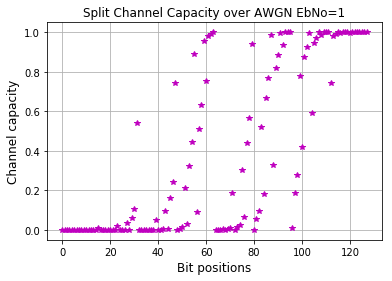

Z:
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99997360e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99994722e-01
 1.00000000e+00 9.99989457e-01 9.99978962e-01 9.90847560e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99979872e-01
 1.00000000e+00 9.99959834e-01 9.99920026e-01 9.82194386e-01
 9.99999995e-01 9.99853698e-01 9.99709883e-01 9.66224465e-01
 9.99031477e-01 9.38726304e-01 8.96507557e-01 4.60087617e-01
 1.00000000e+00 9.99999996e-01 9.99999992e-01 9.99822614e-01
 9.99999969e-01 9.99647595e-01 9.99304453e-01 9.47949102e-01
 9.99999639e-01 9.98799012e-01 9.97655829e-01 9.05510889e-01
 9.93063151e-01 8.40361354e-01 7.56058260e-01 2.56132568e-01
 9.99989053e-01 9.93393689e-01 9.87515795e-01 7.89018728e-01
 9.68241360e-01 6.75339560e-01 5.56326915e-01 1.11497293e-01
 9.10445656e-01 4.91041707e-01 3.68244979e-01 4.20946535e-02
 2.44830901e-01 1.71597792e-02 9.17141685e-03 2.11257097e-05
 1.00000000e+00 9.99

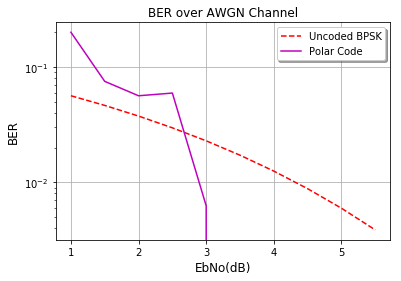

In [2]:
"""
Created on Tue Aug 27 19:46:45 2019
Edited on Mon Sept 2, 10:20, 2019
Tue Sept 10,2019
SCD_AWGN.py
@author: Young Joon Song
"""
import numpy as np
import scipy.special as sp
from matplotlib import pyplot as plt

np.random.seed(103)
n_power=7
CodeRate=0.5
N_length=int(2**n_power)
msg_length=int(CodeRate*N_length)
frozen_length=N_length-msg_length

TotalNumMessage=10
EbNo_Start=1.0  # in dB
EbNo_delta=0.5 # in dB
EbNo_Numbers=10 
EbNo=np.arange(EbNo_Start,EbNo_Start+EbNo_Numbers*EbNo_delta,EbNo_delta)
ebno=10.**(EbNo/10.)          # dB to real value 변환
BER_BPSK_Uncoded=0.5*sp.erfc(np.sqrt(ebno))      # BPSK BER 공식

file=open("SCDAWGN.txt","w")
file.write("BER for polar code over AWGN channel of code length ")
file.write(str(N_length))
file.write("\n")
file.write(", Total number of messages: ")
file.write(str(TotalNumMessage))
file.write("\n")
file.write("EbNo(dB):  BER:   \n ")


def BhanttacharyyaParameterAWGN():
    EbNo_Real=1
    InitialValue=np.exp(-1*CodeRate*EbNo_Real)
    Z_before=[]
    Z_after=[]
    CapacitySplit=np.ones(N_length)
    Z_index_sorted=np.arange(N_length)
    Z_before.append(InitialValue)  # Initial value of Bhattacharyya parameter #
    i=0
    while (i < n_power):
        N_half=len(Z_before)
        for j in range(N_half):
            Z_Value=2*Z_before[j]-Z_before[j]**2
            if Z_Value < 10**-10: Z_Value=10**-10
            elif Z_Value > (1 - 10**-10): Z_Value=1 - 10**-10
            Z_after.append(Z_Value)
            
            Z_Value=Z_before[j]**2
            if Z_Value < 10**-10: Z_Value=10**-10
            elif Z_Value > (1 - 10**-10): Z_Value=1 - 10**-10
            Z_after.append(Z_Value)
#        print("Z:",Z_after)    
        Z_before=Z_after
        Z_after=[]
        i+=1
        
    Z_after=np.array(Z_before)
    CapacitySplit=CapacitySplit-Z_after
    plt.plot(np.arange(N_length),CapacitySplit,'m*')
    plt.xlabel("Bit positions",size=12)
    plt.ylabel("Channel capacity",size=12)
    plt.title('Split Channel Capacity over AWGN EbNo=1')
    plt.grid(True)
    plt.show()
    #######################################################


    Z_after=np.array(Z_before)
    Z_sorted=sorted(Z_before,reverse=True)
    for i in range(N_length):
        Z_index_sorted[i]=Z_before.index(Z_sorted[i])
        Z_before[Z_index_sorted[i]]=-99
    return (Z_after, Z_index_sorted)
   
def AllGeneratorMatrixPolarCode():
    GenAll={}
    g_before=np.ones([1,1])
    GenAll[0]=g_before
    n_variable=0
    while (n_variable < n_power):
        n_col_before=2**n_variable # number of columns for g_before matrix
        n_row_before=2**n_variable # number of rows for g_before matrix
        n_variable+=1
        g_after=np.ones([2**n_variable,2**n_variable])
        for i in range(n_col_before):
            g_after[0:n_col_before,2*i]=g_before[:,i]
            g_after[0:n_col_before,2*i+1]=np.zeros(n_col_before)
            g_after[n_row_before::,2*i]=g_before[:,i]
            g_after[n_row_before::,2*i+1]=g_before[:,i]
#        print(g_after)
        g_before=g_after
        GenAll[n_variable]=g_before
    return GenAll

'''
from Decimal to Bits in List type of lenght BitLength.
From the left to right bit positios, the order is from MSB to LSB.
'''
def D2B(BitLength,DecimalNum): 
    BinList=list(bin(DecimalNum))
    del BinList[0:2]
    Len_BinList=len(BinList)
    for i in range(Len_BinList): BinList[i]=int(BinList[i]) 
    if Len_BinList>BitLength:
        print('Not enough BitLength , DecimalNum is too big. I will return empty List []. Try again!!\n')
        return []
    elif Len_BinList==BitLength: return BinList
    else:
        diff_len=BitLength-Len_BinList
        while(diff_len>0):
            BinList.insert(0,0)
            diff_len-=1
        return BinList

def B2D(Bin_vector): ## binary to decimal conversion
    Decimal_num=0
    for i in range(len(Bin_vector)):
        Decimal_num += Bin_vector[i]*2**(len(Bin_vector)-1-i)
    return int(Decimal_num)

def NodeOutValue(L_In,R_In):
    LEFT=np.exp(L_In)
    RIGHT=np.exp(R_In)
    N_Out=np.log(1+LEFT*RIGHT)-np.log(LEFT+RIGHT)
    if N_Out >= 77: N_Out=77
    elif N_Out < -77: N_Out=-77
    return round(N_Out,5)

def NodeOutValueRef(L_In,R_In,Ref):
    N_Out=((-1)**Ref)*L_In + R_In
    if N_Out >= 77: N_Out=77
    elif N_Out < -77: N_Out=-77
    return round(N_Out,5)
        
G_All=AllGeneratorMatrixPolarCode()
#print('All Gen:\n',G_All)

(Z_AWGN,Z_decending_index_AWGN)=BhanttacharyyaParameterAWGN()
print("Z:\n",Z_AWGN)
#print("index sorted:",Z_decending_index_AWGN)

SelectedBitsPositions=np.ones(msg_length)
for i in range(msg_length):
    SelectedBitsPositions[i]=Z_decending_index_AWGN[frozen_length+i]
#print('SelectedBitsPositions',SelectedBitsPositions)
SelectedBitsPositions.sort()
print('Sorted SelectedBitsPositions',SelectedBitsPositions)

FrozenBitsPositions=np.ones(frozen_length)
for i in range(N_length-msg_length):
    FrozenBitsPositions[i]=Z_decending_index_AWGN[i]
#print('Frozen Bits Positions:',FrozenBitsPositions)

FrozenBitsPositions.sort()
print('sorted Frozen Bits Positions:',FrozenBitsPositions)


BERs=[]
for EbNo_cnt, EbNo_real in enumerate(ebno):
    Sigma=np.sqrt(1/(2.0*EbNo_real*CodeRate))
    TotalErrorBits=0
    for _ in range(TotalNumMessage):
        msg=np.random.randint(0,2,size=msg_length)
#        print('message bits:',msg)
        uncodedbits=np.zeros(N_length)
        decodedbits=[]
        for i in range(msg_length):
            uncodedbits[int(SelectedBitsPositions[i])]=msg[i]
    #    print("uncoded bits with frozen",uncodedbits)  
        G=G_All[n_power]
    #    print('Generator Matrix:\n',G)
        codeword=np.matmul(uncodedbits,G)%2
#         print("polar codeword:",codeword)
        ReceviedAWGN=(-1)**codeword+np.random.normal(0,Sigma,N_length)
#         print(ReceviedAWGN)
        LR_AWGN=np.exp(4*EbNo_real*CodeRate*ReceviedAWGN) #필요없음
        LLR_AWGN=4*EbNo_real*CodeRate*ReceviedAWGN
#         print('LLR AWGN',LLR_AWGN)
        
        Remain_FBPositions=list(FrozenBitsPositions)
        
        for CurrentBitNumber in range(N_length):
            Binary_CurrentBitNumber=D2B(n_power,CurrentBitNumber)
            length_Remain_FBPositions=len(Remain_FBPositions)
            FrozenBitAssigned = False
            if (length_Remain_FBPositions>0):
                if (Remain_FBPositions[0] == CurrentBitNumber):
                    FrozenBitAssigned = True
                    decodedbits.append(0)
                    del Remain_FBPositions[0]
    #                print("Frozen bit '0' is added and the current decoded bits are:\n",decodedbits)
                    
            if (FrozenBitAssigned==False):
    #            print('index of Bit to be decoded:',CurrentBitNumber)
    #            print('Binary of bit index:',Binary_CurrentBitNumber)
                TreeNodeBitNumbers={}
                for TreeLevelNo in range(n_power):
                    NodeBitSize=Binary_CurrentBitNumber[(n_power-1)-TreeLevelNo]*(2**TreeLevelNo)
                    TreeNodeBitNumbers[TreeLevelNo]=NodeBitSize
    #                print('Tree Bit numbers',TreeNodeBitNumbers)
          
                cnt_TreeAssignedBits=0
                TreeAssignedBits={}
                TreeLevelNo=n_power-1
                while (cnt_TreeAssignedBits < CurrentBitNumber):
                    TreeAssignedBits[TreeLevelNo]=decodedbits[cnt_TreeAssignedBits:cnt_TreeAssignedBits+TreeNodeBitNumbers[TreeLevelNo]]
                    cnt_TreeAssignedBits+=TreeNodeBitNumbers[TreeLevelNo]
                    TreeLevelNo-=1
    #                print('Assigned bits:',TreeAssignedBits)
                
                NodeInputs=LLR_AWGN
                for TreeLevelNo in range(n_power-1,-1,-1):
                    NodeNum=int(2**TreeLevelNo)
                    NodeOutputs=np.ones(NodeNum)
                    if (TreeNodeBitNumbers[TreeLevelNo] == 0):
                        for NodeCnt in range(NodeNum):
                            LeftInput=NodeInputs[2*NodeCnt]
                            RightInput=NodeInputs[2*NodeCnt+1]
                            NodeOutputs[NodeCnt]=NodeOutValue(LeftInput,RightInput)
                    else:
                        NodeControlValues=np.matmul(TreeAssignedBits[TreeLevelNo],G_All[TreeLevelNo])%2
    #                    print('Node control bits:',NodeControlValues)
                        for NodeCnt in range(NodeNum):
                            LeftInput=NodeInputs[2*NodeCnt]
                            RightInput=NodeInputs[2*NodeCnt+1]
                            Ref_Value=NodeControlValues[NodeCnt]
                            NodeOutputs[NodeCnt]=NodeOutValueRef(LeftInput,RightInput,Ref_Value)
                            
                    NodeInputs=NodeOutputs
        #            print("Node Outputs:",NodeOutputs)
                if (NodeOutputs[0] >= 0):
                    decodedbits.append(0)
                else:
                    decodedbits.append(1)
    #            print('Decoded bits:',decodedbits)
                
        EstimatedMessage=[]
        for i in range(msg_length):
            EstimatedMessage.append(decodedbits[int(SelectedBitsPositions[i])])
#        print("Estimated message is:",EstimatedMessage)
        NumErrors=0
        for i in range(msg_length):
            if (EstimatedMessage[i] != msg[i]): NumErrors+=1
#        print('Error count:',NumErrors)
        TotalErrorBits+=NumErrors
        ber=NumErrors/msg_length
    #    print('ber:',ber)
    BER=TotalErrorBits/(msg_length*TotalNumMessage)
    print('EbNo(dB):',EbNo[EbNo_cnt],'  BER::',BER)
    BERs.append(BER)
    file.write(str(EbNo[EbNo_cnt]));file.write("        "); file.write(str(BER))
    file.write("\n")

print('EbNo:',EbNo)
print('BERs for each EbNo:',BERs)
plt.title('BER over AWGN Channel')
plt.plot(EbNo,BER_BPSK_Uncoded,'r--',EbNo,BERs,'m-')
plt.yscale('log')
plt.xlabel('EbNo(dB)',size=12)
plt.ylabel('BER',size=12)
plt.legend(('Uncoded BPSK','Polar Code'),loc=0, shadow=True)
plt.grid(True)
plt.show()
file.close()
   
